In [81]:
import pandas as pd
import numpy as np
import sklearn as sk
from IPython.display import display
DATASET = pd.read_csv('Titanic-Dataset.csv')
display(DATASET.head(6))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


In [52]:
display(DATASET.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [53]:
DATASET.fillna({'Embarked': 'Unknown'}, inplace=True)
print(f"пропусков в Embarked: {int(DATASET['Embarked'].isna().sum())}")

пропусков в Embarked: 0


In [54]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import zlib  # для стабильного хэша

class CabinFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, cabin_col: str = "Cabin", add_hash: bool = False,
                 n_buckets: int = 128, drop_original: bool = False):
        self.cabin_col = cabin_col
        self.add_hash = add_hash
        self.n_buckets = n_buckets
        self.drop_original = drop_original

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X = X.copy()

        col = self.cabin_col
        if col not in X.columns:   # проверяем именно входной X
            return X

        s = X[col].fillna("").astype(str).str.strip()
        tokens = s.str.split()
        first_tok = tokens.str[0].fillna("")

        # 1) есть ли каюта
        X["cabin_present"] = (s != "").astype(int)

        # 2) палуба: первая буква, иначе Unknown
        deck_letter = first_tok.str.extract(r"^([A-Za-z])", expand=False)
        X["deck"] = deck_letter.fillna("Unknown")

        # 3) сколько токенов (кают) указано
        X["cabin_count"] = tokens.apply(lambda x: len(x) if isinstance(x, list) else 0).astype(int)

        # 4) есть ли цифры в первом токене
        X["cabin_num_exists"] = first_tok.str.contains(r"\d", regex=True).astype(int)  # <-- с 's'

        # 5) стабильный хэш (опция)
        if self.add_hash:
            X["cabin_hash"] = first_tok.apply(
                lambda t: zlib.crc32(t.encode("utf-8")) % self.n_buckets
            ).astype(int)

        if self.drop_original:
            X = X.drop(columns=[col])

        return X 


In [55]:
target_col = 'Survived'
y = DATASET[target_col].astype(int)
X = DATASET.drop(columns=[target_col])
cat_cols = ["Sex", "Embarked", "deck"]
num_cols = [ "Pclass", "Age", "SibSp", "Parch", "Fare",
    "cabin_present", "cabin_count", "cabin_num_exists"]


In [56]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

num_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='median')), 
    ('sc', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

prep = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ],
    remainder='drop'
)

pipe_logreg = Pipeline([
    ('cabin_feat', CabinFeaturizer(cabin_col='Cabin', add_hash=True, drop_original=True)),
    ('prep', prep),
    ('clf', LogisticRegression(max_iter=2000))
])

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

res = cross_validate(
    pipe_logreg,
    X, y,
    cv=CV,
    scoring=scoring,
    n_jobs=1,
    return_train_score=False
)

print("LogReg 5-fold CV")
print("  accuracy: %.3f ± %.3f" % (res["test_accuracy"].mean(), res["test_accuracy"].std()))
print("  f1      : %.3f ± %.3f" % (res["test_f1"].mean(),       res["test_f1"].std()))
print("  roc_auc : %.3f ± %.3f" % (res["test_roc_auc"].mean(),  res["test_roc_auc"].std()))

svm_pipeline = Pipeline([
    ('cabin_feat', CabinFeaturizer(cabin_col="Cabin", add_hash=False, drop_original=True)),
    ('prep', prep),
     ("clf", SVC(kernel="rbf", probability=True))
])

res_svm = cross_validate(
    svm_pipeline,
    X,y,
    cv=CV,
    scoring=scoring,
    return_train_score=False
)
print("SVM (RBF) 5-fold CV")
print("  accuracy: %.3f ± %.3f" % (res_svm["test_accuracy"].mean(), res_svm["test_accuracy"].std()))
print("  f1      : %.3f ± %.3f" % (res_svm["test_f1"].mean(),       res_svm["test_f1"].std()))
print("  roc_auc : %.3f ± %.3f" % (res_svm["test_roc_auc"].mean(),  res_svm["test_roc_auc"].std()))

pipe_knn = Pipeline([
    ("cabin_feat", CabinFeaturizer(cabin_col="Cabin", add_hash=False, drop_original=True)),
    ("prep", prep),  
    ("clf", KNeighborsClassifier(n_neighbors=5, weights="uniform", metric="minkowski", p=2))
])

res_knn = cross_validate(
    pipe_knn, X, y, cv=CV, scoring=scoring, n_jobs=-1, return_train_score=False
)
print("KNN (k=5) 5-fold CV")
print("  accuracy: %.3f ± %.3f" % (res_knn["test_accuracy"].mean(), res_knn["test_accuracy"].std()))
print("  f1      : %.3f ± %.3f" % (res_knn["test_f1"].mean(),       res_knn["test_f1"].std()))
print("  roc_auc : %.3f ± %.3f" % (res_knn["test_roc_auc"].mean(),  res_knn["test_roc_auc"].std()))

LogReg 5-fold CV
  accuracy: 0.789 ± 0.035
  f1      : 0.720 ± 0.047
  roc_auc : 0.854 ± 0.035
SVM (RBF) 5-fold CV
  accuracy: 0.816 ± 0.028
  f1      : 0.748 ± 0.045
  roc_auc : 0.853 ± 0.035
KNN (k=5) 5-fold CV
  accuracy: 0.805 ± 0.023
  f1      : 0.739 ± 0.024
  roc_auc : 0.825 ± 0.027


D:\anaconda\Lib\site-packages\matplotlib\colors.py:2242: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
D:\anaconda\Lib\site-packages\matplotlib\colors.py:2249: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
D:\anaconda\Lib\site-packages\matplotlib\ticker.py:561: UserWarning: Warning: converting a masked element to nan.
  else fmt % arg)


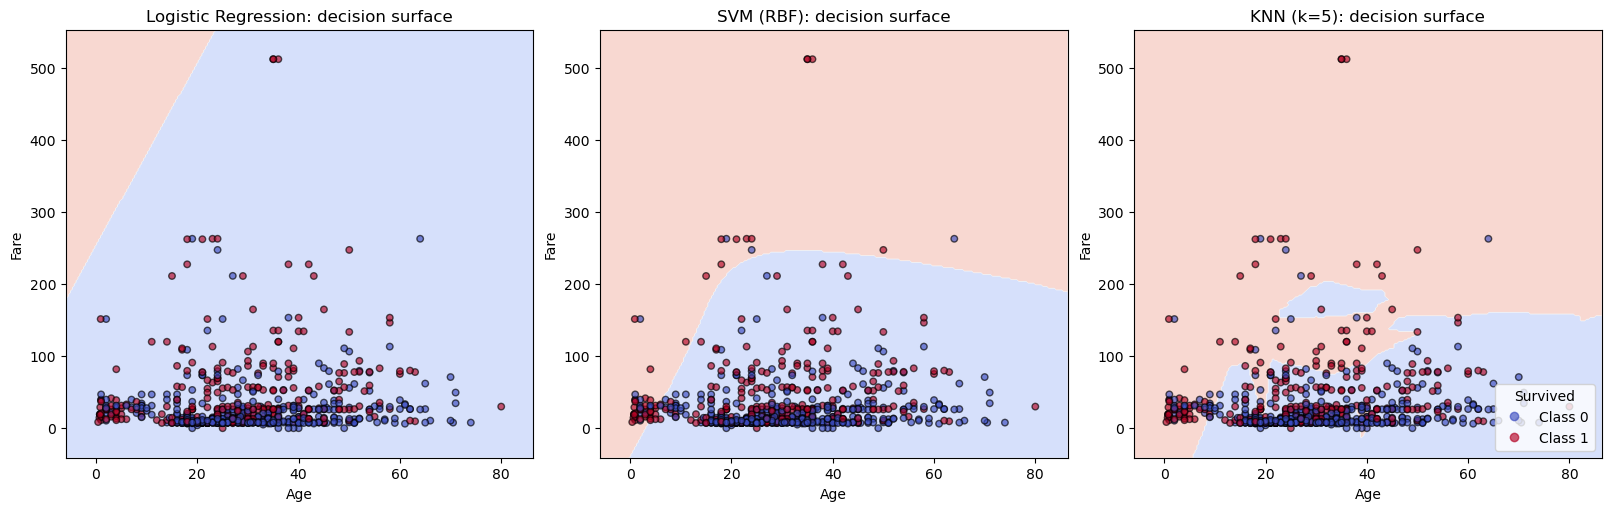

In [68]:
import pandas as pd


def _typical_values_row(df: pd.DataFrame) -> pd.Series:
    """
    Возвращает одну строку с типичными значениями по всем столбцам df:
    - для числовых: медиана
    - для остальных: мода (первое наиболее частое непропущенное значение)
    Если моды нет (все NaN) — подставляет пустую строку.
    """
    num_med = df.select_dtypes(include=[np.number]).median()
    non_num = df.drop(columns=num_med.index, errors="ignore")
    if non_num.shape[1] > 0:
        modes = non_num.mode(dropna=True)
        mode_row = modes.iloc[0] if not modes.empty else pd.Series(index=non_num.columns, dtype=object)
        mode_row = mode_row.fillna("")
    else:
        mode_row = pd.Series(dtype=object)

    base = pd.Series(index=df.columns, dtype=object)
    base.loc[num_med.index] = num_med
    base.loc[mode_row.index] = mode_row
    base = base.fillna("")
    return base

def plot_decision_surfaces_3(
    X: pd.DataFrame,
    y: pd.Series,
    pipe_logreg,
    pipe_svm,
    pipe_knn,
    x_col: str = "Age",
    y_col: str = "Fare",
    grid_size: int = 250,
    padding: float = 0.08,
    point_alpha: float = 0.65
):
    """
    Рисует 3 разделяющие поверхности (LogReg, SVM, KNN) в координатах (x_col, y_col),
    пропуская всё через полный Pipeline. Остальные признаки фиксируются типичными значениями.
    Ничего не “фитит” на всём X вне функции: используется clone(estimator) внутри.
    """
    # проверки
    if x_col not in X.columns or y_col not in X.columns:
        missing = [c for c in [x_col, y_col] if c not in X.columns]
        raise ValueError(f"В X отсутствуют колонки для осей: {missing}")

    # 1) типичные значения остальных фич
    base_row = _typical_values_row(X) 

    # 2) диапазоны сетки
    x_vals = X[x_col].dropna()
    y_vals = X[y_col].dropna()
    if x_vals.empty or y_vals.empty:
        raise ValueError("Недостаточно данных в выбранных осях для построения сетки (все NaN?).")

    x_min, x_max = x_vals.min(), x_vals.max()
    y_min, y_max = y_vals.min(), y_vals.max()
    x_pad = (x_max - x_min) * padding
    y_pad = (y_max - y_min) * padding
    x_lin = np.linspace(x_min - x_pad, x_max + x_pad, grid_size)
    y_lin = np.linspace(y_min - y_pad, y_max + y_pad, grid_size)
    xx, yy = np.meshgrid(x_lin, y_lin)
    n = xx.size

    # 3) датафрейм для предсказаний: все колонки X, заполнены базовыми значениями
    #    (это важно, чтобы CabinFeaturizer и ColumnTransformer видели все исходные поля)
    grid_df = pd.DataFrame([base_row.values] * n, columns=X.columns)
    grid_df[x_col] = xx.ravel()
    grid_df[y_col] = yy.ravel()


    lr_vis  = clone(pipe_logreg)
    svm_vis = clone(pipe_svm)
    knn_vis = clone(pipe_knn)

    lr_vis.fit(X, y)
    svm_vis.fit(X, y)
    knn_vis.fit(X, y)

    Z_lr  = lr_vis.predict(grid_df).reshape(xx.shape)
    Z_svm = svm_vis.predict(grid_df).reshape(xx.shape)
    Z_knn = knn_vis.predict(grid_df).reshape(xx.shape)

    X2 = X[[x_col, y_col]].copy()
    colors = y.values

    # 7) рисуем
    fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)
    panels = [
        ("Logistic Regression", Z_lr),
        ("SVM (RBF)",           Z_svm),
        ("KNN (k=5)",           Z_knn),
    ]

    for ax, (title, Z) in zip(axes, panels):
        ax.contourf(xx, yy, Z, alpha=0.28, levels=2, cmap=plt.cm.coolwarm, antialiased=True)
        sc = ax.scatter(X2[x_col], X2[y_col], c=colors, cmap=plt.cm.coolwarm,
                        edgecolor="k", alpha=point_alpha, s=22)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_title(f"{title}: decision surface")

    handles, _ = sc.legend_elements()
    axes[-1].legend(handles, ["Class 0", "Class 1"], title="Survived", loc="lower right")
    plt.show()
    
plot_decision_surfaces_3(
    X=X.copy(), y=y,
    pipe_logreg=pipe_logreg, pipe_svm=svm_pipeline, pipe_knn=pipe_knn,
    x_col="Age", y_col="Fare"
)

In [58]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === SVM (RBF) ===
param_grid_svm = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", 0.1, 0.01],
    "clf__class_weight": [None, "balanced"],
}
gs_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    scoring="roc_auc",      
    cv=cv,
    n_jobs=-1,
    refit=True,            
    verbose=0
)
gs_svm.fit(X, y)
print("SVM best params:", gs_svm.best_params_)
print("SVM CV ROC-AUC:", gs_svm.best_score_)

# === KNN ===
param_grid_knn = {
    "clf__n_neighbors": [3, 5, 7, 9, 11],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2],              
}
gs_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid_knn,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)
gs_knn.fit(X, y)
print("KNN best params:", gs_knn.best_params_)
print("KNN CV ROC-AUC:", gs_knn.best_score_)


summary = pd.DataFrame([
    {"Model":"SVM (RBF)", "CV ROC-AUC": gs_svm.best_score_, "Best params": gs_svm.best_params_},
    {"Model":"KNN",       "CV ROC-AUC": gs_knn.best_score_, "Best params": gs_knn.best_params_},
])
summary


SVM best params: {'clf__C': 1, 'clf__class_weight': None, 'clf__gamma': 0.01}
SVM CV ROC-AUC: 0.8608611876051869
KNN best params: {'clf__n_neighbors': 9, 'clf__p': 1, 'clf__weights': 'uniform'}
KNN CV ROC-AUC: 0.8604947430616733


,Model,CV ROC-AUC,Best params
0,SVM (RBF),0.860861,"{'clf__C': 1, 'clf__class_weight': None, 'clf_..."
1,KNN,0.860495,"{'clf__n_neighbors': 9, 'clf__p': 1, 'clf__wei..."


Посмотрим на важность признаков

Sex            0.211171
Pclass         0.042671
Age            0.025019
Cabin          0.006916
SibSp          0.006897
Fare           0.002331
Embarked       0.001886
Name           0.000000
PassengerId    0.000000
Ticket         0.000000
Parch         -0.001244
dtype: float64
cat__Sex_male            0.052262
cat__Sex_female          0.051305
num__Pclass              0.042671
num__Age                 0.025019
num__cabin_num_exists    0.012046
num__SibSp               0.006897
num__cabin_count         0.002435
num__Fare                0.002331
cat__deck_C              0.001360
cat__Embarked_S          0.001162
cat__deck_F              0.000608
num__cabin_present       0.000404
cat__deck_D              0.000291
cat__deck_G              0.000244
cat__Embarked_Unknown    0.000021
cat__deck_B              0.000015
cat__deck_E              0.000012
cat__deck_T              0.000000
cat__Embarked_C         -0.000289
cat__deck_Unknown       -0.000302
dtype: float64


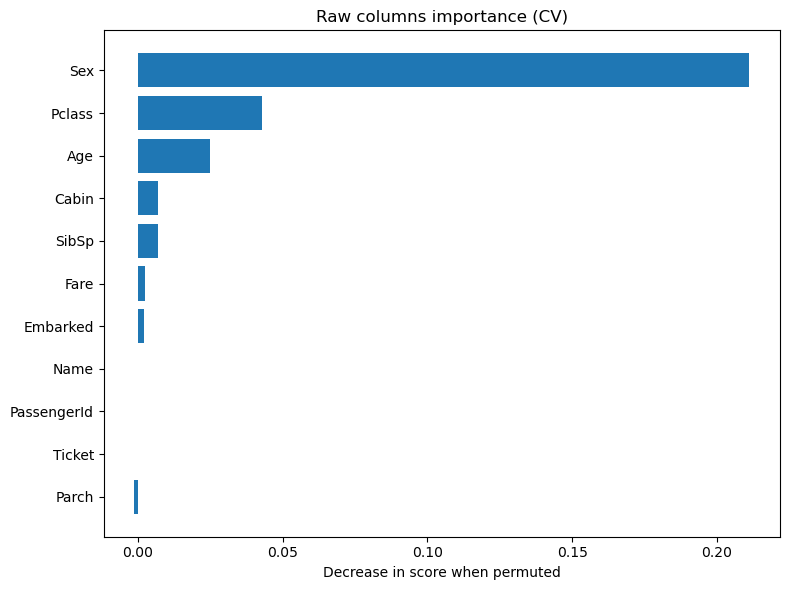

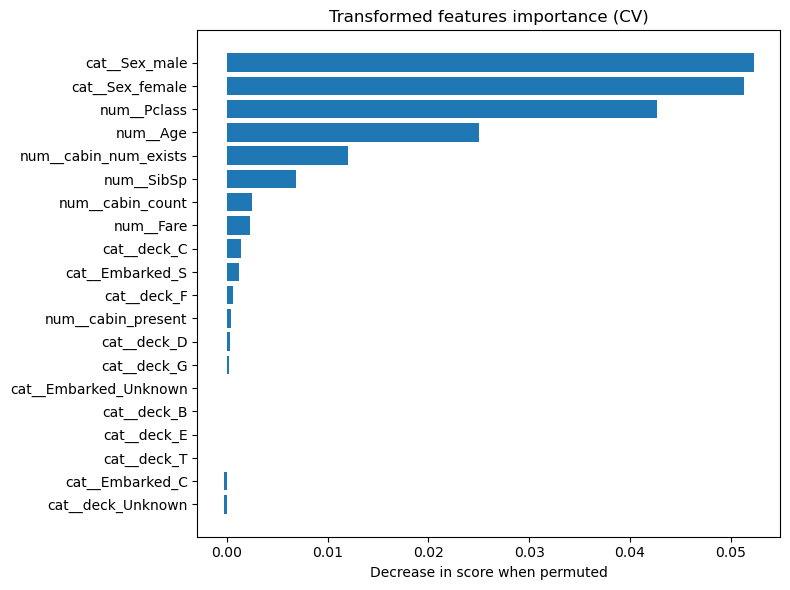

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def perm_importance_raw_cols(pipeline, X: pd.DataFrame, y: pd.Series, cv, scoring="roc_auc"):
    """Возвращает средние permutation importances по исходным колонкам X, усреднённые по фолдам."""
    importances_all = []

    for tr_idx, te_idx in cv.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        pipeline.fit(X_tr, y_tr)
        # permutation_importance сам будет дергать pipeline.predict/ predict_proba
        r = permutation_importance(
            pipeline, X_te, y_te,
            n_repeats=10, random_state=42, scoring=scoring, n_jobs=-1
        )
        fold_imp = pd.Series(r.importances_mean, index=X.columns)
        importances_all.append(fold_imp)

    imp_df = pd.concat(importances_all, axis=1).mean(axis=1).sort_values(ascending=False)
    return imp_df

best_pipe_A = pipe_logreg  # или gs_svm.best_estimator_, или лучший KNN
imp_raw = perm_importance_raw_cols(best_pipe_A, X, y, cv, scoring="roc_auc")
print(imp_raw.head(15))

import matplotlib.pyplot as plt

def plot_topk_importances(imp_series: pd.Series, k=20, title="Permutation importance (top-k)"):
    topk = imp_series.head(k)[::-1]  # снизу вверх
    plt.figure(figsize=(8, 6))
    plt.barh(topk.index, topk.values)
    plt.title(title)
    plt.xlabel("Decrease in score when permuted")
    plt.tight_layout()
    plt.show()

from sklearn.base import clone
from sklearn.inspection import permutation_importance

def get_transformed_feature_names(fitted_pipe) -> np.ndarray:
    """Имена колонок после ColumnTransformer (работает после .fit)."""
    prep = fitted_pipe.named_steps["prep"]
    return prep.get_feature_names_out()

def perm_importance_transformed_cols(pipeline, X: pd.DataFrame, y: pd.Series, cv, scoring="roc_auc"):
    """Permutation importance по колонкам ПОСЛЕ препроцессинга, усреднённый по фолдам."""
    results = []

    for tr_idx, te_idx in cv.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        pipe = clone(pipeline).fit(X_tr, y_tr)

        # 1) трансформим валид до матрицы признаков
        X_te_trans = pipe.named_steps["prep"].transform(
            pipe.named_steps["cabin_feat"].transform(X_te)
        )
        feat_names = get_transformed_feature_names(pipe)

        # 2) берём финальный классификатор и меряем importance по его входу
        clf = pipe.named_steps["clf"]
        r = permutation_importance(
            clf, X_te_trans, y_te,
            n_repeats=10, random_state=42, scoring=scoring, n_jobs=-1
        )
        fold_imp = pd.Series(r.importances_mean, index=feat_names)
        results.append(fold_imp)

    imp_df = pd.concat(results, axis=1).mean(axis=1).sort_values(ascending=False)
    return imp_df

imp_trans = perm_importance_transformed_cols(best_pipe_A, X, y, cv, scoring="roc_auc")
print(imp_trans.head(20))

# рисуем
plot_topk_importances(imp_raw, k=15, title="Raw columns importance (CV)")
plot_topk_importances(imp_trans, k=20, title="Transformed features importance (CV)")


In [79]:
# ==== Ветка B: базовые модели + честная CV, единый запуск ====
import re
import numpy as np
import pandas as pd
import sklearn

from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from catboost import CatBoostClassifier

set_config(transform_output="pandas")

cat_cols_B = ["Sex", "Embarked", "deck"]
num_cols_B = ["Pclass", "Age", "SibSp", "Parch", "Fare",
              "cabin_present", "cabin_count", "cabin_num_exists"]

# плотный OHE (совместим с pandas-выходом)
def make_ohe_dense():
    ver = tuple(int(x) for x in sklearn.__version__.split(".")[:2])
    return OneHotEncoder(handle_unknown="ignore",
                         sparse_output=False if ver >= (1,4) else False)

num_pipe_B = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
])

cat_pipe_B = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe_dense())
])

prep_B = ColumnTransformer(
    transformers=[
        ("num", num_pipe_B, num_cols_B),
        ("cat", cat_pipe_B, cat_cols_B),
    ],
    remainder="drop"
)

# 2) Базовые модели (DT / RF / GB) — общий препроцесс
pipe_dt = Pipeline([
    ("cabin_feat", CabinFeaturizer(cabin_col="Cabin", add_hash=False, drop_original=True)),
    ("prep", prep_B),
    ("clf", DecisionTreeClassifier(random_state=42))
])

pipe_rf = Pipeline([
    ("cabin_feat", CabinFeaturizer(cabin_col="Cabin", add_hash=False, drop_original=True)),
    ("prep", prep_B),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=1))  
])

pipe_gb = Pipeline([
    ("cabin_feat", CabinFeaturizer(cabin_col="Cabin", add_hash=False, drop_original=True)),
    ("prep", prep_B),
    ("clf", GradientBoostingClassifier(random_state=42))
])

# 3) CatBoost-пайплайн: берём только нужные столбцы и заполняем категории
cat_cols_cb = ["Sex", "Embarked", "deck"]
num_cols_cb = ["Pclass", "Age", "SibSp", "Parch", "Fare",
               "cabin_present", "cabin_count", "cabin_num_exists"]
select_cols_cb = cat_cols_cb + num_cols_cb

def select_columns_cb(df: pd.DataFrame) -> pd.DataFrame:
    keep = [c for c in select_cols_cb if c in df.columns]
    return df[keep]

def fill_categories(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in cat_cols_cb:
        if c in df.columns:
            df[c] = df[c].astype("object").fillna("Unknown")
    for c in num_cols_cb:
        if c in df.columns and df[c].dtype.kind in "fc" and df[c].isna().any():
            df[c] = df[c].fillna(df[c].median())
    return df

select_tf = FunctionTransformer(select_columns_cb)
fill_tf   = FunctionTransformer(fill_categories)
select_tf.set_output(transform="pandas")
fill_tf.set_output(transform="pandas")

pipe_cat = Pipeline([
    ("cabin_feat", CabinFeaturizer(cabin_col="Cabin", add_hash=False, drop_original=True)),
    ("select", select_tf),
    ("fill_cats", fill_tf),
    ("clf", CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=5,
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=42,
        verbose=0
    ))
])

# ВАЖНО: CatBoost должен заранее знать категориальные колонки (по именам)
pipe_cat.set_params(clf__cat_features=cat_cols_cb)

# 4) Честная CV для всех моделей
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1": make_scorer(f1_score),
    "roc_auc": "roc_auc"
}

models = {
    "DecisionTree": pipe_dt,
    "RandomForest": pipe_rf,
    "GradientBoosting": pipe_gb,
    "CatBoost": pipe_cat,
}

rows = []
for name, mdl in models.items():

    cvres = cross_validate(mdl, X, y, cv=cv, scoring=scoring, n_jobs=1, return_train_score=False)
    rows.append({
        "Model": name,
        "Acc_mean":  cvres["test_accuracy"].mean(), "Acc_std":  cvres["test_accuracy"].std(),
        "F1_mean":   cvres["test_f1"].mean(),       "F1_std":   cvres["test_f1"].std(),
        "AUC_mean":  cvres["test_roc_auc"].mean(),  "AUC_std":  cvres["test_roc_auc"].std(),
    })

report = pd.DataFrame(rows).sort_values("AUC_mean", ascending=False).reset_index(drop=True)
print(report.to_string(index=False, float_format=lambda v: f"{v:.3f}"))


           Model  Acc_mean  Acc_std  F1_mean  F1_std  AUC_mean  AUC_std
GradientBoosting     0.841    0.029    0.774   0.043     0.875    0.028
        CatBoost     0.824    0.022    0.755   0.030     0.872    0.021
    RandomForest     0.806    0.032    0.745   0.035     0.866    0.030
    DecisionTree     0.779    0.035    0.713   0.038     0.769    0.026


In [61]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold


class OOFTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, n_splits=5, smoothing=10.0, noise=0.0,
                 drop_original=True, random_state=42):
        self.cols = cols
        self.n_splits = n_splits
        self.smoothing = float(smoothing)
        self.noise = float(noise)
        self.drop_original = drop_original
        self.random_state = random_state
        # learned
        self.global_mean_ = None
        self.mapping_ = {}  # {col: pd.Series(category -> value)}

    def fit(self, X, y):
        X = pd.DataFrame(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        self.global_mean_ = float(y.mean())
        self.mapping_ = {}
        for col in self.cols:
            if col not in X.columns:
                continue
            grp = X[col].astype(str).fillna("Unknown")
            stats = y.groupby(grp).agg(["mean", "count"])
            smoothed = (stats["count"] * stats["mean"] + self.smoothing * self.global_mean_) / (
                    stats["count"] + self.smoothing)
            self.mapping_[col] = smoothed
        return self

    def fit_transform(self, X, y):
        X = pd.DataFrame(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        X_out = X.copy()

        # заготовим TE-колонки
        for col in self.cols:
            X_out[f"{col}_TE"] = np.nan

        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        for tr_idx, val_idx in kf.split(X):
            X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
            X_val = X.iloc[val_idx]

            for col in self.cols:
                if col not in X.columns:
                    continue
                grp_tr = X_tr[col].astype(str).fillna("Unknown")
                stats = y_tr.groupby(grp_tr).agg(["mean", "count"])
                fold_mean = float(y_tr.mean())
                smoothed = (stats["count"] * stats["mean"] + self.smoothing * fold_mean) / (
                        stats["count"] + self.smoothing)

                grp_val = X_val[col].astype(str).fillna("Unknown")
                te_val = grp_val.map(smoothed).fillna(fold_mean).values  # np.array

                # позиционная запись через iloc
                te_col_idx = X_out.columns.get_loc(f"{col}_TE")
                X_out.iloc[val_idx, te_col_idx] = te_val

        # добивка NaN, шум, обучение глобального mapping’а
        for col in self.cols:
            te_col = f"{col}_TE"
            X_out[te_col] = X_out[te_col].astype(float).fillna(y.mean())
            if self.noise > 0:
                rng = np.random.RandomState(self.random_state)
                X_out[te_col] = X_out[te_col] * (1 + self.noise * rng.normal(size=len(X_out)))

        self.fit(X, y)
        if self.drop_original:
            X_out = X_out.drop(columns=[c for c in self.cols if c in X_out.columns])
        return X_out

    def transform(self, X):
        X = pd.DataFrame(X).reset_index(drop=True)
        X_out = X.copy()
        for col in self.cols:
            grp = X[col].astype(str).fillna("Unknown") if col in X.columns else pd.Series(["Unknown"] * len(X))
            mapping = self.mapping_.get(col, pd.Series(dtype=float))
            te = grp.map(mapping).fillna(self.global_mean_)
            if self.noise > 0:
                rng = np.random.RandomState(self.random_state)
                te = te * (1 + self.noise * rng.normal(size=len(te)))
            X_out[f"{col}_TE"] = te.values
        if self.drop_original:
            X_out = X_out.drop(columns=[c for c in self.cols if c in X_out.columns])
        return X_out


# добавим TE-колонку в список числовых
num_cols_B_te = ["Pclass", "Age", "SibSp", "Parch", "Fare",
                 "cabin_present", "cabin_count", "cabin_num_exists",
                 "Ticket_TE"]  # <— новая фича
import sklearn
from sklearn.preprocessing import OneHotEncoder

def make_ohe():
    ver = tuple(int(x) for x in sklearn.__version__.split(".")[:2])
    if ver >= (1, 4):
        # Плотный вывод (dense) вместо sparse
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    else:
        # Для старых версий аналог — sparse=False
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)

pipe_rf_te = Pipeline([
    ("cabin_feat", CabinFeaturizer(cabin_col="Cabin", add_hash=False, drop_original=True)),
    ("ticket_te", OOFTargetEncoder(cols=["Ticket"], n_splits=5, smoothing=10.0, noise=0.0, drop_original=True)),
    ("prep", ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), num_cols_B_te),  # числовые только импутим
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("ohe", make_ohe())
            ]), cat_cols_B),
        ],
        remainder="drop"
    )),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
])

pipe_gb_te = Pipeline([
    ("cabin_feat", CabinFeaturizer(cabin_col="Cabin", add_hash=False, drop_original=True)),
    ("ticket_te", OOFTargetEncoder(cols=["Ticket"], n_splits=5, smoothing=10.0, noise=0.0, drop_original=True)),
    ("prep", ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), num_cols_B_te),
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("ohe", make_ohe())
            ]), cat_cols_B),
        ],
        remainder="drop"
    )),
    ("clf", GradientBoostingClassifier(random_state=42))
])
# добавим Ticket в cat-фичи CatBoost
cat_cols_cb = ["Sex", "Embarked", "deck", "Ticket"]
num_cols_cb = ["Pclass", "Age", "SibSp", "Parch", "Fare",
               "cabin_present", "cabin_count", "cabin_num_exists"]
select_cols_cb = cat_cols_cb + num_cols_cb


def select_columns_cb(df: pd.DataFrame) -> pd.DataFrame:
    keep = [c for c in select_cols_cb if c in df.columns]
    return df[keep]


def fill_categories(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in cat_cols_cb:
        if c in df.columns:
            df[c] = df[c].astype("object").fillna("Unknown")
    for c in num_cols_cb:
        if c in df.columns and df[c].dtype.kind in "fc" and df[c].isna().any():
            df[c] = df[c].fillna(df[c].median())
    return df


# обновим пайплайн pipe_cat (как ты уже чинил раньше)
pipe_cat = Pipeline([
    ("cabin_feat", CabinFeaturizer(cabin_col="Cabin", add_hash=False, drop_original=True)),
    ("select", FunctionTransformer(select_columns_cb)),
    ("fill_cats", FunctionTransformer(fill_categories)),
    ("clf", CatBoostClassifier(
        iterations=600, learning_rate=0.1, depth=6,
        loss_function="Logloss", eval_metric="AUC",
        random_seed=42, verbose=0
    ))
])
pipe_cat.named_steps["clf"].set_params(cat_features=cat_cols_cb)
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score
# после создания пайплайна для деревьев
ohe = make_ohe()
cat_pipe_B = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

prep_B = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols_B),
        ("cat", cat_pipe_B, cat_cols_B),
    ],
    remainder="drop"
)

# ключевая строка: у этого препроцессора вернуть "обычный" (numpy/sparse) выход
prep_B.set_output(transform="default")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1": make_scorer(f1_score),
    "roc_auc": "roc_auc",
}

models_B_te = {
    "RandomForest + TE(Ticket)": pipe_rf_te,
    "GradientBoosting + TE(Ticket)": pipe_gb_te,
    "CatBoost (+ raw Ticket)": pipe_cat
}

rows = []
for name, pipe in models_B_te.items():
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    rows.append({
        "Model": name,
        "Accuracy_mean": res["test_accuracy"].mean(),
        "Accuracy_std": res["test_accuracy"].std(),
        "F1_mean": res["test_f1"].mean(),
        "F1_std": res["test_f1"].std(),
        "ROC_AUC_mean": res["test_roc_auc"].mean(),
        "ROC_AUC_std": res["test_roc_auc"].std(),
    })

report_B4 = pd.DataFrame(rows).sort_values("ROC_AUC_mean", ascending=False).reset_index(drop=True)
print(report_B4.to_string(index=False, float_format=lambda v: f"{v:.3f}"))


                        Model  Accuracy_mean  Accuracy_std  F1_mean  F1_std  ROC_AUC_mean  ROC_AUC_std
GradientBoosting + TE(Ticket)          0.845         0.017    0.785   0.027         0.887        0.026
    RandomForest + TE(Ticket)          0.815         0.044    0.753   0.053         0.878        0.035
      CatBoost (+ raw Ticket)          0.826         0.028    0.768   0.035         0.877        0.024


In [62]:
# ======= FAST, NO-CACHE, NO-PARALLEL, SELF-CONTAINED =======
import re
import numpy as np
import pandas as pd
import sklearn

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    StratifiedKFold, KFold, RandomizedSearchCV, cross_validate
)
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# ----------------- 1) CabinFeaturizer -----------------
class CabinFeaturizer(BaseEstimator, TransformerMixin):
    """
    Извлекает из 'Cabin':
      - cabin_present (1/0)
      - deck (буква палубы, Unknown)
      - cabin_count (сколько кабин в ячейке, если перечислены)
      - cabin_num_exists (есть ли цифры)
    Можно дропнуть исходную колонку.
    """
    def __init__(self, cabin_col="Cabin", add_hash=False, n_buckets=128, drop_original=True):
        self.cabin_col = cabin_col
        self.add_hash = add_hash
        self.n_buckets = int(n_buckets)
        self.drop_original = drop_original

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        col = self.cabin_col
        if col not in X.columns:
            # обеспечим выходные фичи даже если колонки нет
            X["cabin_present"] = 0
            X["deck"] = "Unknown"
            X["cabin_count"] = 0
            X["cabin_num_exists"] = 0
            return X

        s = X[col].fillna("").astype(str).str.strip()
        tokens = s.str.split()
        first_tok = tokens.str[0].fillna("")

        X["cabin_present"] = (s != "").astype(int)
        # одна буква в начале токена, если есть
        deck_letter = first_tok.str.extract(r"^([A-Za-z])", expand=False)
        X["deck"] = deck_letter.fillna("Unknown")
        X["cabin_count"] = tokens.apply(lambda z: len(z) if isinstance(z, list) else 0).astype(int)
        X["cabin_num_exists"] = first_tok.str.contains(r"\d").fillna(False).astype(int)

        if self.add_hash:
            X["cabin_hash"] = (first_tok.apply(lambda t: hash(t)) % self.n_buckets).astype(int)

        if self.drop_original and col in X.columns:
            X = X.drop(columns=[col])
        return X

# ----------------- 2) FeatureEngineer -----------------
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Добавляет:
      - FamilySize = SibSp + Parch + 1
      - IsAlone = (FamilySize == 1)
      - FarePerPerson = Fare / max(FamilySize,1)
      - Title из Name (с нормализацией редких)
      - TicketPrefix из Ticket (буквенная часть)
    """
    def __init__(self, add_family=True, add_fare_per_person=True,
                 add_title=True, add_ticket_prefix=True, drop_name=True):
        self.add_family = add_family
        self.add_fare_per_person = add_fare_per_person
        self.add_title = add_title
        self.add_ticket_prefix = add_ticket_prefix
        self.drop_name = drop_name

    def _extract_title(self, name: str) -> str:
        if not isinstance(name, str):
            return "Unknown"
        m = re.search(r",\s*([^\.]+)\.", name)
        title = m.group(1).strip() if m else "Unknown"
        mapping = {
            "Mlle":"Miss","Ms":"Miss","Mme":"Mrs",
            "Lady":"Rare","Countess":"Rare","Capt":"Rare","Col":"Rare","Don":"Rare",
            "Dr":"Rare","Major":"Rare","Rev":"Rare","Sir":"Rare","Jonkheer":"Rare","Dona":"Rare"
        }
        return mapping.get(title, title)

    def _ticket_prefix(self, t: str) -> str:
        if not isinstance(t, str):
            return "Unknown"
        t = t.replace(".", "").replace("/", " ").strip()
        letters = re.sub(r"\s+", " ", "".join(ch for ch in t if not ch.isdigit())).strip()
        return letters if letters else "None"

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        # FamilySize / IsAlone
        if self.add_family:
            if {"SibSp","Parch"}.issubset(X.columns):
                X["FamilySize"] = (
                    pd.to_numeric(X["SibSp"], errors="coerce").fillna(0).astype(float) +
                    pd.to_numeric(X["Parch"], errors="coerce").fillna(0).astype(float) + 1
                ).astype(float)
                X["IsAlone"] = (X["FamilySize"] == 1).astype(int)
            else:
                X["FamilySize"] = np.nan
                X["IsAlone"] = np.nan

        # FarePerPerson
        if self.add_fare_per_person:
            if "Fare" in X.columns:
                fare = pd.to_numeric(X["Fare"], errors="coerce")
                fare = fare.fillna(fare.median())
                denom = X["FamilySize"].fillna(1).clip(lower=1) if "FamilySize" in X.columns else 1.0
                X["FarePerPerson"] = (fare / denom).astype(float)
            else:
                X["FarePerPerson"] = np.nan

        # Title
        if self.add_title:
            X["Title"] = X["Name"].apply(self._extract_title).astype(object) if "Name" in X.columns else "Unknown"

        # TicketPrefix
        if self.add_ticket_prefix:
            X["TicketPrefix"] = (
                X["Ticket"].astype(str).apply(self._ticket_prefix).astype(object)
                if "Ticket" in X.columns else "Unknown"
            )

        if self.drop_name and "Name" in X.columns:
            X = X.drop(columns=["Name"])

        return X

# ----------------- 3) OOF Target Encoder (Ticket) -----------------
class OOFTargetEncoder(BaseEstimator, TransformerMixin):
    """
    OOF target encoding для указанных колонок (здесь используем ['Ticket']).
    Без утечек: внутри KFold, запись по .iloc (позиционно).
    """
    def __init__(self, cols, n_splits=3, smoothing=10.0, noise=0.0, drop_original=True, random_state=42):
        self.cols = cols
        self.n_splits = int(n_splits)
        self.smoothing = float(smoothing)
        self.noise = float(noise)
        self.drop_original = drop_original
        self.random_state = random_state
        self.global_mean_ = None
        self.mapping_ = {}

    def _add_noise(self, s: pd.Series) -> pd.Series:
        if self.noise > 0:
            rng = np.random.RandomState(self.random_state)
            return s * (1 + self.noise * rng.normal(size=len(s)))
        return s

    def fit(self, X, y):
        X = pd.DataFrame(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        self.global_mean_ = float(y.mean())
        self.mapping_.clear()

        for col in self.cols:
            if col not in X.columns:
                continue
            grp = X[col].astype(str).fillna("Unknown")
            stats = y.groupby(grp).agg(["mean","count"])
            smoothed = (stats["count"]*stats["mean"] + self.smoothing*self.global_mean_) / (stats["count"] + self.smoothing)
            self.mapping_[col] = smoothed
        return self

    def fit_transform(self, X, y):
        X = pd.DataFrame(X).reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        X_out = X.copy()
        for col in self.cols:
            X_out[f"{col}_TE"] = np.nan

        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        for tr_idx, val_idx in kf.split(X):
            X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
            X_val = X.iloc[val_idx]
            for col in self.cols:
                if col not in X.columns:
                    continue
                grp_tr = X_tr[col].astype(str).fillna("Unknown")
                stats = y_tr.groupby(grp_tr).agg(["mean","count"])
                fold_mean = float(y_tr.mean())
                smoothed = (stats["count"]*stats["mean"] + self.smoothing*fold_mean) / (stats["count"] + self.smoothing)
                grp_val = X_val[col].astype(str).fillna("Unknown")
                te_val = grp_val.map(smoothed).fillna(fold_mean).values
                te_col_idx = X_out.columns.get_loc(f"{col}_TE")
                X_out.iloc[val_idx, te_col_idx] = te_val

        # добивка NaN + шум
        for col in self.cols:
            te_col = f"{col}_TE"
            X_out[te_col] = X_out[te_col].astype(float).fillna(y.mean())
            X_out[te_col] = self._add_noise(X_out[te_col])

        # обучим глобальный mapping на всём train (для .transform)
        self.fit(X, y)

        if self.drop_original:
            X_out = X_out.drop(columns=[c for c in self.cols if c in X_out.columns])
        return X_out

    def transform(self, X):
        X = pd.DataFrame(X).reset_index(drop=True)
        X_out = X.copy()
        for col in self.cols:
            if col in X.columns:
                grp = X[col].astype(str).fillna("Unknown")
            else:
                grp = pd.Series(["Unknown"] * len(X))
            mapping = self.mapping_.get(col, pd.Series(dtype=float))
            te = grp.map(mapping).fillna(self.global_mean_)
            te = self._add_noise(te)
            X_out[f"{col}_TE"] = te.values
        if self.drop_original:
            X_out = X_out.drop(columns=[c for c in self.cols if c in X_out.columns])
        return X_out

# ----------------- 4) Helper: dense OHE -----------------
def make_ohe_dense():
    ver = tuple(int(x) for x in sklearn.__version__.split(".")[:2])
    # для sklearn>=1.4 правильный флаг — sparse_output=False; для более старых — sparse=False
    return OneHotEncoder(handle_unknown="ignore", sparse_output=False) if ver >= (1,4) \
           else OneHotEncoder(handle_unknown="ignore", sparse=False)

# ----------------- 5) Списки признаков после FE -----------------
cat_cols_B = ["Sex","Embarked","deck","Title","TicketPrefix"]
num_cols_B_base = ["Pclass","Age","SibSp","Parch","Fare",
                   "cabin_present","cabin_count","cabin_num_exists",
                   "FamilySize","IsAlone","FarePerPerson"]
num_cols_B_te = num_cols_B_base + ["Ticket_TE"]

# ----------------- 6) Препроцессор (без pandas-output, без кэша) -----------------
prep_B_te = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols_B_te),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", make_ohe_dense())
        ]), cat_cols_B),
    ],
    remainder="drop"
)
# ВАЖНО: НЕ делаем set_output("pandas"), оставляем default (numpy) — стабильнее и быстрее.

# ----------------- 7) Пайплайны (без memory) -----------------
pipe_gb_te = Pipeline([
    ("cabin_feat", CabinFeaturizer(cabin_col="Cabin", add_hash=False, drop_original=True)),
    ("fe", FeatureEngineer()),
    ("ticket_te", OOFTargetEncoder(cols=["Ticket"], n_splits=3, smoothing=10.0, noise=0.0, drop_original=True)),
    ("prep", prep_B_te),
    ("clf", GradientBoostingClassifier(random_state=42))
])

# (опционально, для ориентировочной метрики — быстрый RF)
pipe_rf_te = Pipeline([
    ("cabin_feat", CabinFeaturizer(cabin_col="Cabin", add_hash=False, drop_original=True)),
    ("fe", FeatureEngineer()),
    ("ticket_te", OOFTargetEncoder(cols=["Ticket"], n_splits=3, smoothing=10.0, noise=0.0, drop_original=True)),
    ("prep", prep_B_te),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=1))
])

# ----------------- 8) Быстрая самопроверка перед поиском -----------------
def sanity_check_steps(X, y):
    Xt = pipe_gb_te.named_steps["cabin_feat"].transform(X)
    Xt = pipe_gb_te.named_steps["fe"].transform(Xt)
    Xt = pipe_gb_te.named_steps["ticket_te"].fit_transform(Xt, y)
    miss_num = [c for c in num_cols_B_te if c not in Xt.columns]
    miss_cat = [c for c in cat_cols_B if c not in Xt.columns]
    print("Missing num:", miss_num)   # должны быть пустые списки
    print("Missing cat:", miss_cat)

# Пример: раскомментируй для проверки
# sanity_check_steps(X, y)

# ----------------- 9) Быстрый RandomizedSearchCV для GB (без параллелизма, без кэша) -----------------
cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
param_dist_gb = {
    "clf__n_estimators": [300, 600],
    "clf__learning_rate": [0.05, 0.08],
    "clf__max_depth": [2, 3],
    "clf__min_samples_leaf": [1, 5],
    "clf__subsample": [0.85, 1.0],
    "clf__max_features": [None, "sqrt"],
}

rs_gb = RandomizedSearchCV(
    estimator=pipe_gb_te,
    param_distributions=param_dist_gb,
    n_iter=12,
    scoring="roc_auc",
    cv=cv_fast,
    n_jobs=1,              # ключ: без параллелизма -> без пиклинга локальных классов
    random_state=42,
    refit=True,
    verbose=2,
    error_score="raise"    # покажет реальную ошибку, если всплывёт
)


# ----------------- 10) Быстрая CV-сводка (3-fold) -----------------
def cv_report(model, X, y, cv):
    scoring = {"accuracy": make_scorer(accuracy_score),
               "f1": make_scorer(f1_score),
               "roc_auc": "roc_auc"}
    cvres = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=1)
    return {m: (cvres[f"test_{m}"].mean(), cvres[f"test_{m}"].std()) for m in ["accuracy","f1","roc_auc"]}


print("RF+TE (fast)  3-fold:", cv_report(pipe_rf_te, X, y, cv_fast))


RF+TE (fast)  3-fold: {'accuracy': (np.float64(0.8092031425364757), np.float64(0.01563231007540307)), 'f1': (np.float64(0.7404083148161971), np.float64(0.02592668403866031)), 'roc_auc': (np.float64(0.8735819512351006), np.float64(0.007798294070307038))}


   Accuracy     F1   ROC-AUC
0  0.815642  0.736  0.834914


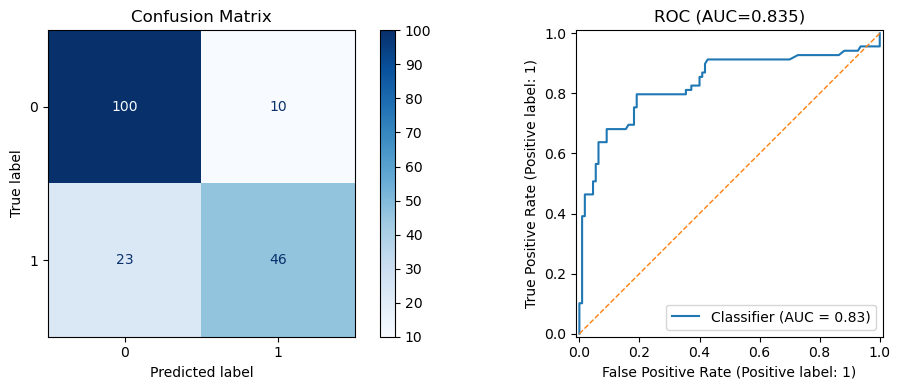


Top-20 permutation importance (by ROC-AUC):


,Feature,Mean ΔAUC,Std
0,Pclass,0.2285,0.0426
1,Embarked,0.0278,0.0092
2,cabin_count,0.0276,0.0147
3,Age,0.0235,0.0081
4,cabin_present,0.0112,0.0076
5,SibSp,0.0108,0.0048
6,cabin_num_exists,0.0069,0.0079
7,Parch,0.0028,0.0016
8,Sex,0.0000,0.0000
9,deck,0.0000,0.0000


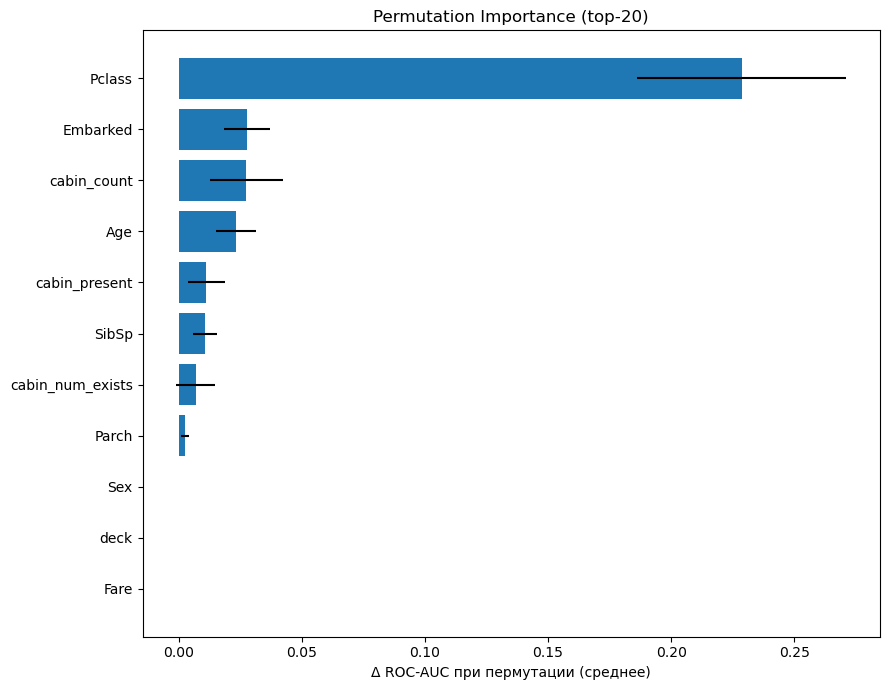

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

model = pipe_cat   

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
model.fit(X_tr, y_tr)

# предсказания
y_pred = model.predict(X_te)
y_prob = None
if hasattr(model, "predict_proba"):
    y_prob = model.predict_proba(X_te)[:,1]
elif hasattr(model, "decision_function"):
    import numpy as np
    z = model.decision_function(X_te)
    y_prob = 1 / (1 + np.exp(-z))

acc = accuracy_score(y_te, y_pred)
f1  = f1_score(y_te, y_pred)
auc = roc_auc_score(y_te, y_prob) if y_prob is not None else float("nan")

print(pd.DataFrame([{"Accuracy":acc, "F1":f1, "ROC-AUC":auc}]))
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

fig, ax = plt.subplots(1, 2, figsize=(11,4))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_te, y_te, cmap="Blues", ax=ax[0])
ax[0].set_title("Confusion Matrix")

# ROC
if y_prob is not None:
    RocCurveDisplay.from_predictions(y_te, y_prob, ax=ax[1])
    ax[1].plot([0,1],[0,1],"--",lw=1)
    ax[1].set_title(f"ROC (AUC={auc:.3f})")
else:
    ax[1].axis("off")
plt.tight_layout(); plt.show()
from sklearn.inspection import permutation_importance
import numpy as np

# --- получаем имена фичей, которыми реально питается модель ---
# это выход последнего трансформера перед clf
Xte_transformed = model[:-1].transform(X_te)   # срез Pipeline: все шаги кроме 'clf'
# благодаря set_config(transform_output="pandas") получаем DataFrame
feature_names = list(Xte_transformed.columns)

# --- permutation importance на всём пайплайне ---
from sklearn.inspection import permutation_importance

r = permutation_importance(
    model, X_te, y_te,
    n_repeats=15, scoring="roc_auc", random_state=42
)

# аккуратная таблица ТОП-20
imp = (
    pd.DataFrame({
        "Feature": feature_names,
        "Mean ΔAUC": r.importances_mean,
        "Std": r.importances_std
    })
    .sort_values("Mean ΔAUC", ascending=False)
    .head(20)
    .reset_index(drop=True)
)

# красивый вывод таблицы
pd.set_option("display.max_colwidth", 60)
print("\nTop-20 permutation importance (by ROC-AUC):")
display(imp.style.format({"Mean ΔAUC": "{:.4f}", "Std": "{:.4f}"}))

# горизонтальный barh с подписями
plt.figure(figsize=(9, 7))
plt.barh(imp["Feature"][::-1], imp["Mean ΔAUC"][::-1], xerr=imp["Std"][::-1])
plt.xlabel("Δ ROC-AUC при пермутации (среднее)")
plt.title("Permutation Importance (top-20)")
plt.tight_layout(); plt.show()

